In [ ]:
import tensorflow as tf
import numpy as np
import sklearn.model_selection as selection
import matplotlib.pyplot as plt

In [ ]:
def make_nn(hidden_sizes, output_size, activation=tf.keras.activations.relu):
    NNLayers = [tf.keras.layers.Dense(h, activation=activation, dtype=tf.float32) for h in hidden_sizes]
    NNLayers.append(tf.keras.layers.Dense(output_size, dtype=tf.float32))
    return tf.keras.Sequential(NNLayers)

  
class Decoder(tf.keras.Model):
  def __init__(self, hidden_sizes, output_size, activation=tf.keras.activations.relu):
    super(Decoder, self).__init__()
    self.network = make_nn(hidden_sizes, output_size, activation=activation)

  def call(self, z):
    out = self.network(z)
    return out

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_sizes, output_size, activation=tf.keras.activations.relu):
        super(Encoder, self).__init__()
        self.network = make_nn(hidden_sizes, output_size, activation=tf.keras.activations.relu)

    def call(self, inputs, training=False):
        return self.network(inputs)

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, input_size, latent_dim, encoder_layers, decoder_layers, activation=tf.keras.activations.relu):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder([input_size]+encoder_layers, self.latent_dim*2, activation=activation)
    self.decoder = Decoder([self.latent_dim]+decoder_layers, input_size, activation=activation)

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(0.5*logvar) + mean

  def call(self, x):
    mean, logvar = tf.split(self.encoder(x), 2, axis=-1)
    z = self.reparameterize(mean, logvar)
    output = self.decoder(z)
    return output

  def sample(self, eps=None, batch_size=100):
    if eps is None:
      eps = tf.random.normal(shape=(batch_size, self.latent_dim))
    return self.decoder(eps)


In [ ]:
class FlattenImage(tf.keras.Model):
    def __init__(self, shape, model, model_kwargs):
        super(FlattenImage, self).__init__()
        self.shape = shape
        self.flat_size = 1
        for i in self.shape:
            self.flat_size *= i
        self.vae = model(input_size=self.flat_size, **model_kwargs)

    def call(self, inputs, training=False):
        x = tf.keras.layers.Flatten()(inputs)
        x = self.vae(x)
        x = tf.reshape(x, (-1, *self.shape, 1))
        return x

In [ ]:
def get_mnist(dataset=tf.keras.datasets.fashion_mnist.load_data, val_split=None, normalise_factor=255.0):
    (x_train, y_train), (x_test, y_test) = dataset()
    x_train = x_train[..., np.newaxis] / normalise_factor
    x_test = x_test[..., np.newaxis] / normalise_factor
    if val_split is not None:
        val_length = int(len(x_train) * val_split)
        x_train, y_train = x_train[:-val_length, ...], y_train[:-val_length, ...]
        x_val, y_val = x_train[-val_length:, ...], y_train[-val_length:, ...]
        x_val = np.float32(x_val)
    else:
        x_val = y_val = None

    x_train = np.float32(x_train)
    x_test = np.float32(x_test)

    train = (x_train, y_train)
    val = (x_val, y_val)
    test = (x_test, y_test)
    return train, val, test

In [ ]:
(x_train, _), (x_val, _), (x_test, _) = get_mnist(val_split=0.2)
#x_train, x_val = selection.train_test_split(x_train)

In [ ]:
print(x_train.shape)
print(x_val.shape)


(48000, 28, 28, 1)
(12000, 28, 28, 1)


In [ ]:
model = FlattenImage((28,28), VAE, {'latent_dim':28, 'encoder_layers':[128], 'decoder_layers':[128]})

In [ ]:
x = model(x_train)
model.compile(optimizer='sgd', loss=tf.keras.losses.KLDivergence())
h = model.fit(x_train, x_train, validation_data=(x_val, x_val), verbose=1, epochs=10) #

Epoch 1/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.9858 - val_loss: 0.6541
Epoch 2/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6542 - val_loss: 0.6373
Epoch 3/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6376 - val_loss: 0.6331
Epoch 4/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.6347 - val_loss: 0.6330
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.6367 - val_loss: 0.6330
Epoch 6/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6349 - val_loss: 0.6329
Epoch 7/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6354 - val_loss: 0.6329
Epoch 8/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6364 - val_loss: 0.6329
Epoch 9/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6322 - val_loss: 0.6295
Epoch 10/10
1500/1500 [==============================] - 13s 9ms/step - l

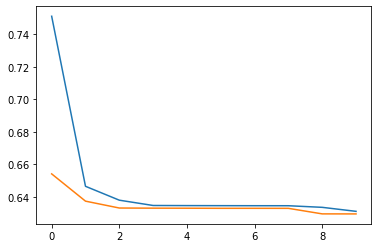

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])